In [102]:
import behavior_two_towers as b
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.ndimage.filters import gaussian_filter1d
import sqlite3 as sql
import os
import pandas as pd
from datetime import datetime
from glob import glob
os.sys.path.append('../')
import utilities

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [189]:

def build_2P_filename(mouse,date,scene,session,serverDir = "G:\\My Drive\\2P_Data\\TwoTower"):
    file=glob("%s\\%s\\%s\\%s\\%s_*%s_*_cnmf_results_pre.mat" % (serverDir, mouse, date, scene, scene, sess))
    if len(file)==0:
        raise Exception("file doesn't exist")
    else:
        return file
    
def build_VR_filename(mouse,date,scene,session,serverDir = "G:\\My Drive\\VR_Data\\TwoTower"):
    file=glob("%s\\%s\\%s\\%s_%s.sqlite" % (serverDir, mouse, date, scene, session))
    if len(file)==1:
        return file[0]
    else:
        print("%s\\%s\\%s\\%s_%s.sqlite" % (serverDir, mouse, date, scene, session))
        raise Exception("file doesn't exist")

def trial_type_dict(mat,type_vec):
    d = {'all': np.squeeze(mat)}
    for i,m in enumerate(np.unique(type_vec)):
        d[m] = d['all'][np.where(type_vec==m)[0],:]
    return d

In [51]:
conn = sql.connect("G:\\My Drive\\VR_Data\\TwoTower\\behavior.sqlite")
df = pd.read_sql("SELECT MouseName, DateFolder, SessionNumber,Track, RewardCount, Imaging FROM sessions",conn)

In [52]:
# find sessions from single mouse on TwoTower_noTimeout with datestring earlier than or equal to first timeout day
# num rewards greater than 

mouse = '4139190.3'
# mouse filter
df = df[df['MouseName'].str.match(mouse)]
df = df[df['RewardCount']>10]
df['DateTime'] = [datetime.strptime(s,'%d_%m_%Y') for s in df['DateFolder']]
df_noTO = df[df['Track']=='TwoTower_noTimeout']
df_TO = df[df['Track']=='TwoTower_Timeout']
df_TO = df_TO.sort_values('DateTime')
df_noTO[df_noTO['DateTime'] < df_TO['DateTime'].iloc[0]]

df_noTO['data file'] = [ build_VR_filename(df_noTO['MouseName'].iloc[i],
                                           df_noTO['DateFolder'].iloc[i],
                                           df_noTO['Track'].iloc[i],
                                           df_noTO['SessionNumber'].iloc[i]) for i in range(df_noTO.shape[0])]

df_noTO = df_noTO.sort_values(by=['DateTime','SessionNumber'])
df_noTO

C:\Users\mplitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,DateTime,data file
237,4139190.3,15_06_2018,1,TwoTower_noTimeout,57,1,2018-06-15,G:\My Drive\VR_Data\TwoTower\4139190.3\15_06_2...
239,4139190.3,15_06_2018,2,TwoTower_noTimeout,35,0,2018-06-15,G:\My Drive\VR_Data\TwoTower\4139190.3\15_06_2...
236,4139190.3,15_06_2018,3,TwoTower_noTimeout,45,1,2018-06-15,G:\My Drive\VR_Data\TwoTower\4139190.3\15_06_2...
238,4139190.3,15_06_2018,4,TwoTower_noTimeout,38,0,2018-06-15,G:\My Drive\VR_Data\TwoTower\4139190.3\15_06_2...
267,4139190.3,16_06_2018,1,TwoTower_noTimeout,52,0,2018-06-16,G:\My Drive\VR_Data\TwoTower\4139190.3\16_06_2...
268,4139190.3,16_06_2018,2,TwoTower_noTimeout,111,0,2018-06-16,G:\My Drive\VR_Data\TwoTower\4139190.3\16_06_2...
298,4139190.3,17_06_2018,1,TwoTower_noTimeout,41,0,2018-06-17,G:\My Drive\VR_Data\TwoTower\4139190.3\17_06_2...
297,4139190.3,17_06_2018,2,TwoTower_noTimeout,109,1,2018-06-17,G:\My Drive\VR_Data\TwoTower\4139190.3\17_06_2...
252,4139190.3,18_06_2018,1,TwoTower_noTimeout,19,0,2018-06-18,G:\My Drive\VR_Data\TwoTower\4139190.3\18_06_2...
250,4139190.3,19_06_2018,1,TwoTower_noTimeout,30,0,2018-06-19,G:\My Drive\VR_Data\TwoTower\4139190.3\19_06_2...


In [134]:
# concatenate desired sessions
frames = []
for i in range(df_noTO.shape[0]):
    sess_conn = sql.connect(df_noTO['data file'].iloc[i])
    frame = pd.read_sql('''SELECT time, pos, dz, morph, lick, reward, tstart, teleport, clickOn, towerJitter
                    , wallJitter, bckgndJitter FROM data''',sess_conn)
   
    # correct dz
    frame.loc[np.abs(frame['dz']>2),'dz']=np.nan
    frame['dz'] = frame['dz'].interpolate()
    frame['speed']=gaussian_filter1d(np.divide(frame['dz'],np.ediff1d(frame['time'],to_begin=0)),10)
    frame['lick rate'] = gaussian_filter1d(np.divide(frame['lick'],np.ediff1d(frame['time'],to_begin=0)),10)
    
    frames.append(frame)
    
    # make sure morph vec is the same for all frames 
data_noTO = pd.concat(frames,ignore_index=True)

C:\Users\mplitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
C:\Users\mplitt\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [211]:
# make speed vs location plots
# correct for frame times
trial_mat, bin_edges, bin_centers = utilities.make_pos_bin_trial_matrices(data_noTO[['speed','morph','lick rate']]._values,
                                              data_noTO['pos']._values,
                                              data_noTO['tstart']._values,
                                              data_noTO['teleport']._values,bin_size=5)
trial_mat[np.isnan(trial_mat)]=0
morph_vec,count = sp.stats.mode(trial_mat[:,:,1],axis=1)
morph_vec = np.squeeze(morph_vec)
print(speed_mat.shape)

(640, 89)


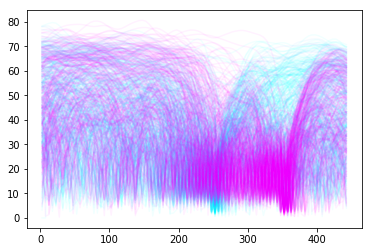

In [212]:
f, ax = plt.subplots()
speed_dict = trial_type_dict(trial_mat[:,:,0],morph_vec)

for i, m in enumerate(np.unique(morph_vec)):
    for j in range(speed_dict[m].shape[0]):
        tmp = ax.plot(bin_centers,speed_dict[m][j,:].T,color=plt.cm.cool(np.float(m)),alpha=.05)


(640, 89) (640,)


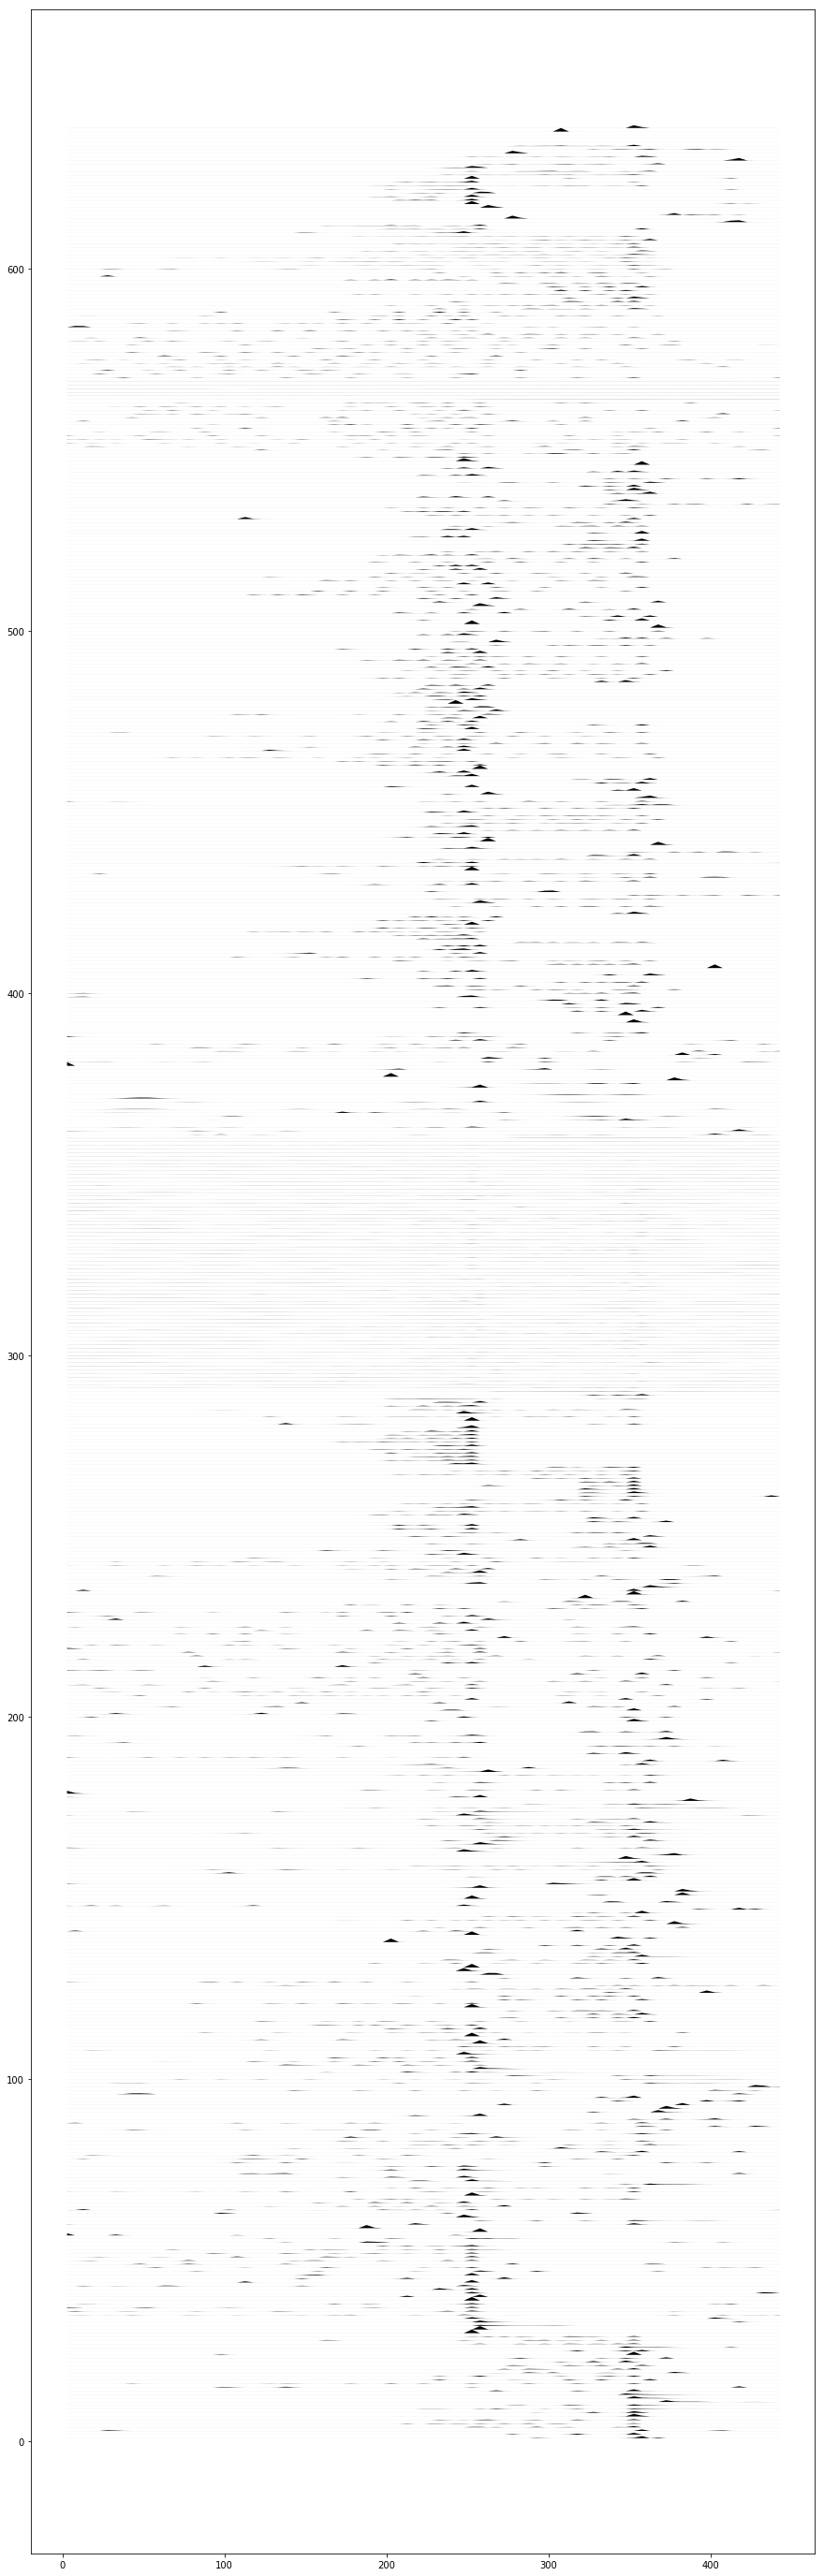

In [222]:
# make lick rate vs position heat maps
f,ax = plt.subplots(figsize=[15,50])
lick_dict = trial_type_dict(trial_mat[:,:,2],morph_vec)

lick_mat = np.squeeze(trial_mat[:,:,2])
lick_mat_norm = np.zeros(lick_mat.shape)
#print(np.amax(lick_dict['all']))
#lick_mat_norm = lick_dict['all']/np.amax(lick_dict['all'])
for i in range(lick_mat_norm.shape[0]):
    if  lick_mat[i,:].sum()>0:
        lick_mat_norm[i,:] = lick_mat[i,:]/lick_mat[i,:].sum()
lick_norm_dict = trial_type_dict(lick_mat_norm,morph_vec)
        
def smooth_raster(x,mat,ax=None,smooth=False,sig=2,vals=None):
    if ax is None:
        f,ax = plt.subplots
    
    if smooth:
        mat = gaussian_filter1d(mat,sig,axis=1)
        
    for ind,i in enumerate(np.arange(mat.shape[0]-1,0,-1)):
        if vals is not None:
            ax.fill_between(x,mat[i,:]+i,y2=i,color=plt.cm.cool(np.float(vals[ind])),linewidth=.01)
        else:
            ax.fill_between(x,mat[i,:]+i,y2=i,color = 'black',linewidth=.01)
            
    return ax

print(lick_norm_dict['all'].shape,morph_vec.shape)
ax = smooth_raster(bin_centers,lick_norm_dict['all'],ax=ax)
        
        
    
# define new function for smoothed raster
    # for each line fill_between, plot and horizontal line
    
# color each line based on morph

# sort and plot each morph independently
#ax[0].imshow(lick_mat_norm0,aspect='auto',cmap='RdPu')
#ax[0].axis='off'
#ax[1].imshow(lick_mat_norm1,aspect='auto',cmap='PuBu')
#ax[1].axis='off'


In [ ]:
#lick rate in front of wrong tower over trials
rzone0, rzone1 = (250.,300.), (350.,400.)

f, ax = plt.subplots(2,1)
for i,m in enumerate(np.unique(morph_vec)):
    
    ### pasted from other notebook, fix this
    zone1_licks = trialMat[:,50:63].mean(axis=1)
    zone2_licks = trialMat[:,70:83].mean(axis=1)
    if m==1:
        ax[0].scatter(np.arange(0,trialMat.shape[0]),zone1_licks,s=5,color=plt.cm.cool(m),alpha=.2)
        ax[0].plot(gaussian_filter(zone1_licks,10),color=plt.cm.cool(m))
        ax[0].set_ylim(0,2e-4)
    if m==0:
        ax[1].scatter(np.arange(0,trialMat.shape[0]),zone2_licks,s=5,color=plt.cm.cool(m),alpha=.2)
        ax[1].plot(gaussian_filter(zone2_licks,10),color=plt.cm.cool(m))
        ax[1].set_ylim(0,4e-4)


In [ ]:
# omission rate

In [ ]:
# lick rate in front of wrong tower over trials averaged over mice

In [ ]:
######### find timeout sessions

In [ ]:
# speed vs location 

In [ ]:
# lick rate

In [ ]:
# lick rate at wrong tower

# cumulative errors (including vs excluding omissions)

In [ ]:
# percent correct vs session

In [ ]:
# percent correct vs wall jitter
    # for each session
    
    # combined

In [ ]:
# percent correct vs tower jitter

In [ ]:
# percent correct vs background jitter